# Health in Old New York

This project is concerned with studying disease incidence in old New York, and hopefully how various interventions at the time aided in mitigating disease. 

At this time, the project relies on ward-level information from [Annual reports of the Board of Health of the City of New York](https://archive.org/details/annualreportofbo1905newy). The previous link points to an example from 1905, and just flipping through the volume can give a clue as to the immense amount of information that is in these books. 

One preliminary goal was to find information that had sufficient spatial and time dimensions for some sort of spatial panel analysis. To this end, Sarah Alshawish assembled a preliminary data set running from 1903 to 1913 that collects information by ward by year, as on page 884-889 of the above-linked document. Incidentally, if you are unfamiliar with the concept of a ward in New York City, [check out some old maps](http://www.historicmapworks.com/Atlas/US/9945/New+York+City+1891+Manhattan+Island/). Eventually, we are going to have to geocode the wards so we can make some live maps as well. 

### Comments

1. I hasten to add that there is a lot of information here - there is stuff on nativity, age distribution, etc. etc., but it is organized in such a way so that deploying all of it might take some thought! 

2. I have chosen to use the [`ipystata` package](https://github.com/TiesdeKok/ipystata) to get started with analysis, as I think that students who might want to get started with this project have more experience with stata. A future thing to do might be to see what can be gleaned from the data using just Python. To install the package, I suggest first downloading and installing the solid [Anaconda distribution of Python](https://www.continuum.io/downloads) and then following the `ipystata` installation instructions at the above-linked `ipystata` site.

Now, some preliminary analysis! First, import `ipystata` and get set the directory path correctly for stata, change directory to this repository's data directory, and then read in the data that we now have:


In [2]:
import ipystata

In [3]:
%%stata -s oldnyc
cd C:\Users\mjbaker\Documents\Github\OldNYCHealth\Data
use 190313Mod.dta, clear
describe


C:\Users\mjbaker\Documents\Github\OldNYCHealth\Data

Contains data from 190313Mod.dta
  obs:           733                          
 vars:            21                          1 Jul 2014 15:14
 size:        65,237                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
year            int     %8.0g                 Year
borough         str2    %9s                   Borough
wards           str14   %14s                  Wards
areainacres     str9    %9s                   Area in acres
population~1900 str9    %9s                   Population by census of 1900
numberofperso~e fl

What we have here are a listing of deaths from a variety of diseases, and also some information on what might be deemed infant mortality - deaths of children under five. Some of the data is a little out of whack, names are too long, strings instead of numbers, etc. Additionally, we compute a few death rates, rather than raw numbers of deaths. Accordingly:

In [1]:
%%stata -s oldnyc

replace  areainacres = subinstr(areainacres, "," ,"" , .)
destring areainacres, replace
rename   areainacres area

replace  populationbycensus = subinstr(populationbycensus, "," ,"" , .)
destring populationbycensus, replace
rename   populationbycensus pop

rename   deathsofchildrenunder5years childdeaths
replace  childdeaths = subinstr(childdeaths, "," ,"" , .)
destring childdeaths, replace

replace  allcauses =subinstr(allcauses, "," ,"" , .)
destring allcauses, replace

gen deathpop  = allcauses/pop*1000
gen death5pop = childdeaths/pop*1000

rename numberofpersonstotheacre popdens

replace diarrhealdiseases = subinstr(diarrhealdiseases, "," ,"" , .)
destring diarrhealdiseases, replace

gen diarpop = diarrhealdiseases/pop*100

ERROR:root:Cell magic `%%stata` not found.


In terms of analysis, we can now make some things that aid in panel analysis of the data: creating ward-level dummies and id variables, `xtsetting` the data, and creating year dummies. Here goes:

In [5]:
%%stata -s oldnyc

gen wardborough = wards + borough
egen id         = group(wardborough)

xtset id year

tab year, gen(yd)


       panel variable:  id (unbalanced)
        time variable:  year, 1903 to 1913, but with a gap
                delta:  1 unit

      Year  |      Freq.     Percent        Cum.
------------+-----------------------------------
       1903 |         67        9.14        9.14
       1904 |         66        9.00       18.14
       1905 |         66        9.00       27.15
       1906 |         66        9.00       36.15
       1907 |         66        9.00       45.16
       1908 |         66        9.00       54.16
       1909 |         66        9.00       63.17
       1910 |         66        9.00       72.17
       1911 |         66        9.00       81.17
       1912 |         69        9.41       90.59
       1913 |         69        9.41      100.00
------------+-----------------------------------
      Total |        733      100.00



### Dummy variable for lower Manhattan

At ome point, we wanted to compare lower Manhattan with everything else, so the following creates a dummy for lower Manhattan. 

In [6]:
%%stata -s oldnyc

gen     lowerMH = 0
replace lowerMH=1 if borough == "MA" & ///
     ( wards == "First"     | wards == "Second"    | wards == "Third"       | wards == "Fourth" | wards == "Fifth" | ///
       wards == "Sixth"     | wards == "Seventh"   | wards == "Eighth"      | wards == "Ninth"  | wards == "Tenth" | ///
       wards == "Eleventh"  | wards == "Twelfth"   | wards == "Thirteenth"  | wards == "Fourteenth"                | ///
       wards == "Fifteenth" | wards == "Sixteenth" | wards == "Seventeenth" | wards == "Eighteenth")


(196 real changes made)



To get an inkling as to what the range of death rates (death rates per 1000, by all diseases) look like, let's just summarize the data without regard to year, and then maybe do the same with the first, last and middle years. Anyways:

(bin=22, start=1.2763097, width=4.1155744)



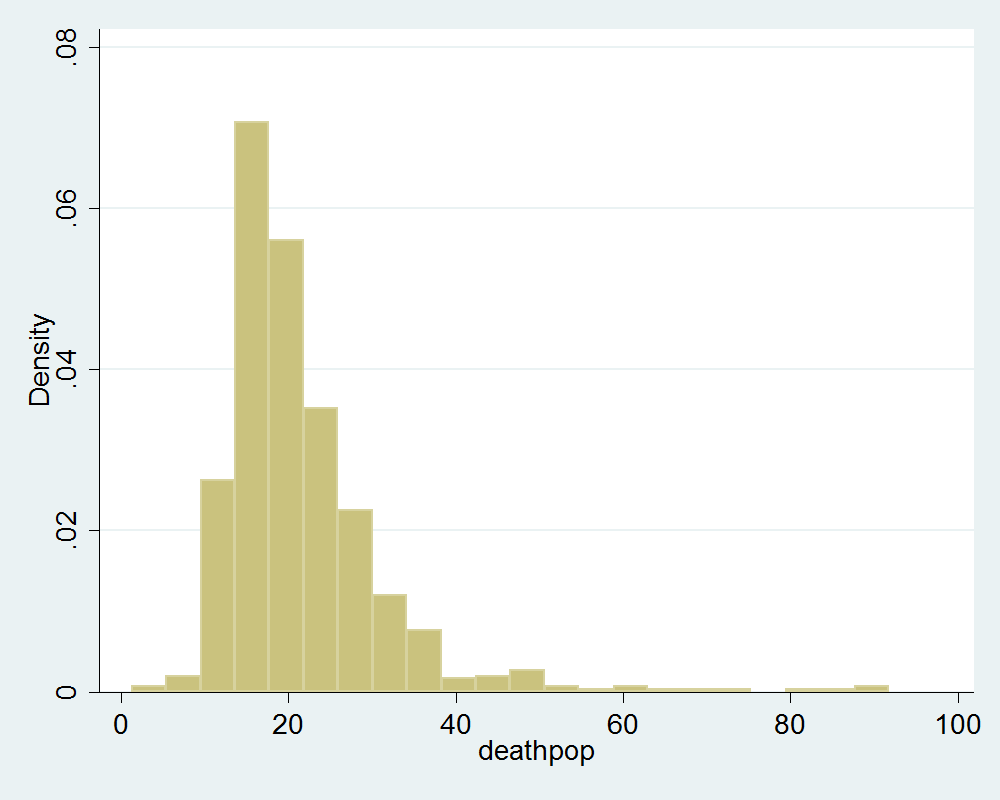

In [7]:
%%stata -s oldnyc -gr
hist deathpop, bin(22)

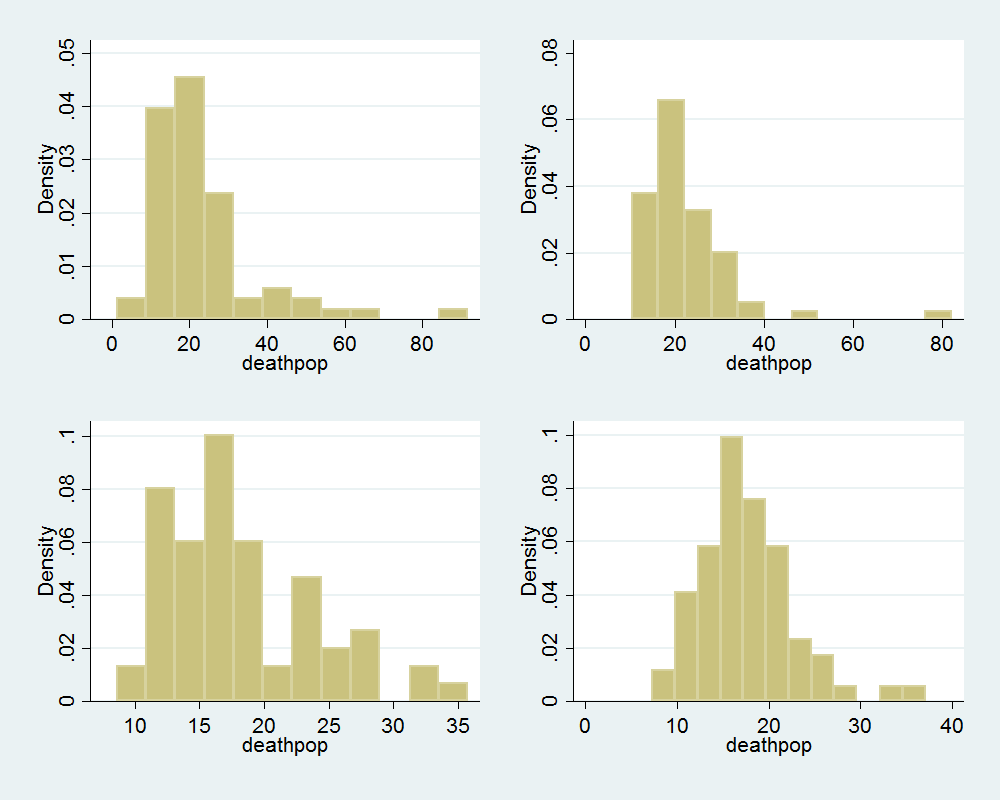

In [8]:
%%stata -s oldnyc -gr
quietly {
    hist deathpop if year == 1903, name(year1903, replace) bin(12)
    hist deathpop if year == 1908, name(year1908, replace) bin(12)
    hist deathpop if year == 1910, name(year1910, replace) bin(12)
    hist deathpop if year == 1913, name(year1913, replace) bin(12)
}
graph combine year1903 year1908 year1910 year1913

We see from the above that really the biggest change from 1903 to 1913 was that one of the most deadly wards kind of had a dramatically lower death rate. This might actually be due to an intervention. What do infant mortality rates look like over this time? 

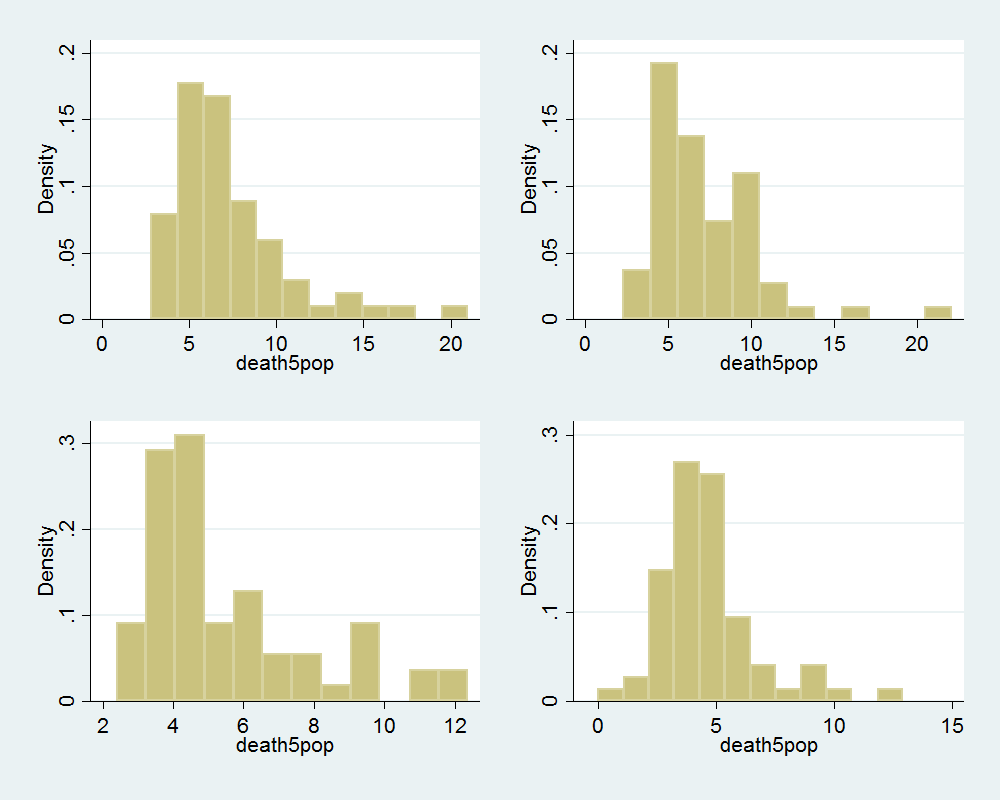

In [9]:
%%stata -s oldnyc -gr
quietly {
    hist death5pop if year == 1903, name(year1903, replace) bin(12)
    hist death5pop if year == 1908, name(year1908, replace) bin(12)
    hist death5pop if year == 1910, name(year1910, replace) bin(12)
    hist death5pop if year == 1913, name(year1913, replace) bin(12)
}
graph combine year1903 year1908 year1910 year1913

# Unhealthy wards

Some of the more unleathy wards...which wards are they and what are they like? 

In [10]:
%%stata -s oldnyc
list year wards borough if deathpop > 45


     +--------------------------------+
     | year           wards   borough |
     |--------------------------------|
148. | 1907           First        MA |
155. | 1903           First        QU |
221. | 1903          Fourth        QU |
276. | 1903           Ninth        MA |
298. | 1903          Second        MA |
     |--------------------------------|
306. | 1911          Second        MA |
307. | 1912          Second        MA |
309. | 1903          Second        QU |
453. | 1904           Third        MA |
455. | 1906           Third        MA |
     |--------------------------------|
456. | 1907           Third        MA |
458. | 1909           Third        MA |
650. | 1906   Twenty-fourth        BX |
651. | 1907   Twenty-fourth        BX |
652. | 1908   Twenty-fourth        BX |
     |--------------------------------|
653. | 1909   Twenty-fourth        BX |
658. | 1903    Twenty-ninth        BR |
659. | 1904    Twenty-ninth        BR |
660. | 1905    Twenty-ninth        BR |

We see some of the worst wards are the first, second, third, and ninth wards in manhattan, the first and fourth in queens, the twenty-ninth in brooklyn, and the twenty fourth in the bronx. This is basically extreme lower manhattan and the modern-day village. The other places are not so easy to determine...

Let's do a few regressions and see what happens. Suppose we do a fixed effects regression using year dummies:

In [11]:
%%stata -s oldnyc
xtreg deathpop  yd2-yd11, fe
xtreg death5pop yd2-yd11, fe


Fixed-effects (within) regression               Number of obs     =        733
Group variable: id                              Number of groups  =         72

R-sq:                                           Obs per group:
     within  = 0.1700                                         min =          1
     between = 0.0472                                         avg =       10.2
     overall = 0.0835                                         max =         11

                                                F(10,651)         =      13.33
corr(u_i, Xb)  = 0.0040                         Prob > F          =     0.0000

------------------------------------------------------------------------------
    deathpop |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         yd2 |   .9906146   1.138177     0.87   0.384    -1.244327    3.225556
         yd3 |   -.384607   1.138177    -0.34   0.736    -2.6195

The most interesting thing about this is the rather dramatic drop that occurred across the board in deaths around yd8 which corresponds, I think, roughly with 1909. Was this due primarily to a drop in infant deaths? Let's try to make a measure of non-infant deaths:

In [38]:
%%stata -s oldnyc

gen deathover5pop  = (allcauses - childdeaths)/pop*1000
xtreg deathover5pop yd2-yd11, fe


Fixed-effects (within) regression               Number of obs     =        733
Group variable: id                              Number of groups  =         72

R-sq:                                           Obs per group:
     within  = 0.0864                                         min =          1
     between = 0.0206                                         avg =       10.2
     overall = 0.0399                                         max =         11

                                                F(10,651)         =       6.16
corr(u_i, Xb)  = 0.0025                         Prob > F          =     0.0000

------------------------------------------------------------------------------
deathover5~p |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         yd2 |   .5227549   .9533459     0.55   0.584    -1.349249    2.394759
         yd3 |   -.403336   .9533459    -0.42   0.672     -2.275

It looks as though it was across all cohorts. Another type of graph to see how things work:

already preserved
r(621);



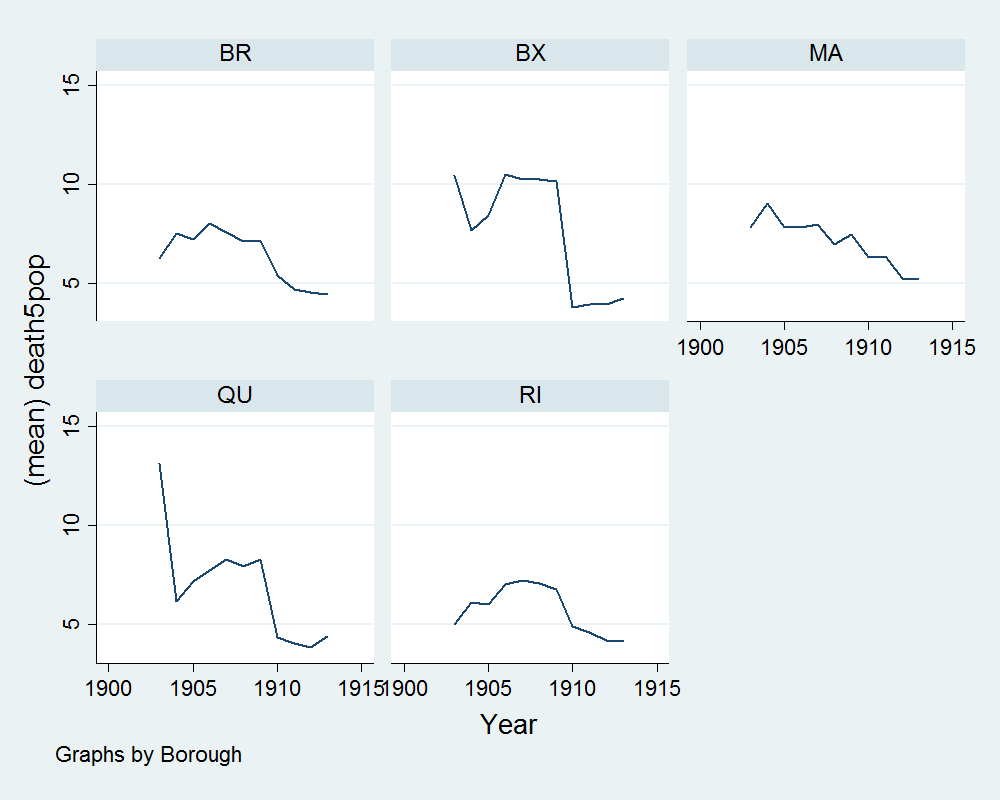

In [45]:
%%stata -s oldnyc -gr

preserve
collapse (mean) deathpop (mean) death5pop, by(borough year)
xtline  deathpop, i(borough) t(year)
xtline death5pop, i(borough) t(year)
restore

## A start...
   
In any event, we now have a little bit of start using and analyzing the data. But there are all kinds of questions, and ways in which this could be extended. One of the first things to do might be to make a accurate ward map of the city.